# Loading the ECCOv4 state estimate fields on the native model grid

## Objectives

Introduce several methods for opening and loading the ECCOv4 state estimate files on the native model grid.

## Introduction 

ECCOv4 native-grid state estimate fields are packaged together as NetCDF files. The ECCOv4 release 4 output files are available from PO.DAAC Cloud via NASA Earthdata, see [this tutorial](https://ecco-v4-python-tutorial.readthedocs.io/Downloading_ECCO_Datasets_from_PODAAC_Python.html) for more information on access. If you already have a NASA Earthdata account, you can download and use the [ecco_download](https://ecco-v4-python-tutorial.readthedocs.io/Downloading_ECCO_Datasets_from_PODAAC_Python.html#ECCO_download-module:-the-quick-and-easy-method) module to access ECCOv4r4 datasets, specifying the dataset [ShortName](https://ecco-v4-python-tutorial.readthedocs.io/Downloading_ECCO_Datasets_from_PODAAC_Python.html#Dataset-ShortNames-and-variables-associated-with-them) you want to download.

For this tutorial, you will need the grid file used in the previous tutorial, and the monthly mean SSH, OBP, and temperature/salinity datasets from 2010-2012. The ShortNames for these datasets are **ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4**, **ECCO_L4_OBP_LLC0090GRID_MONTHLY_V4R4**, and **ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4**. The `ecco_access` library used in the notebook will handle download or retrieval of the necessary data, if you have set up the library [in your Python path](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_intro.html#Setting-up-ecco_access).


## NetCDF File Format

As of March 2023, ECCOv4 release 4 state estimate fields are distributed through PO.DAAC/ NASA Earthdata Cloud, and are stored as NetCDF files, with each file containing one [granule](https://ecco-v4-python-tutorial.readthedocs.io/Downloading_ECCO_Datasets_from_PODAAC_Python.html#ECCO-output-structure-on-PO.DAAC-%28NASA-Earthdata-Cloud%29). Most datasets contain a few related fields, and a granule is a dataset entry at a single time entry: a **monthly mean**, **daily mean**, or a **snapshot** at 0Z on a given day.

Typical file sizes in the LLC90 grid depend on how many fields are contained in a given dataset:

~~~
3D fields:  17-62 MB (2-8 fields x 1 time  x 50 levels x 13 tiles x 90 j x 90 i)
2D fields:  5-7 MB  (1-12 fields x 1 time  x  1 level  x 13 tiles x 90 j x 90 i)
~~~

Notice that there is a not a very large difference in the range of 2D file sizes between a granule of a dataset having 1 field (5 MB) and another dataset having 12 fields (7 MB). This is because most of the space in individual 2D files is occupied by grid parameters. One nice feature of using the ``xarray`` and ``Dask`` libraries is that we do not have to load the entire file contents into RAM to work with them. The ``glob`` and ``xarray`` libraries can also be used together to load multiple files (times) into your workspace as a single dataset, concatenating the data fields without repeating the grid parameters.

## Open/view one ECCOv4 NetCDF file 

In ECCO NetCDF files, all 13 tiles for a given year are aggregated into a single file.  Therefore, we can use the ``open_dataset`` routine from ``xarray`` to open a single NetCDF variable file.

### First set up the environment,  load model grid parameters.

In [1]:
import numpy as np
import xarray as xr
from os.path import join,expanduser
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea


# are you working in the AWS Cloud?
incloud_access = False

# indicate mode of access
# options are:
# 'download': direct download from internet to your local machine
# 'download_ifspace': like download, but only proceeds 
#                     if your machine have sufficient storage
# 's3_open': access datasets in-cloud from an AWS instance
# 's3_open_fsspec': use jsons generated with fsspec and 
#                   kerchunk libraries to speed up in-cloud access
# 's3_get': direct download from S3 in-cloud to an AWS instance
# 's3_get_ifspace': like s3_get, but only proceeds if your instance 
#                   has sufficient storage
user_home_dir = expanduser('~')
download_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')
if incloud_access:
    access_mode = 's3_open_fsspec'
    download_root_dir = None
    jsons_root_dir = join(user_home_dir,'MZZ')
else:
    access_mode = 'download_ifspace'
    download_root_dir = download_dir
    jsons_root_dir = None

In [4]:
## Access datasets needed for this tutorial

grid_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
SSH_monthly_shortname = "ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4"


ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                   "ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_OBP_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4"]

# ecco_podaac_access generates a dictionary whose keys are ShortNames, and whose values 
# are a file path or list of file paths that can be passed to xr.open_dataset or xr.open_mfdataset
files_dict = ea.ecco_podaac_access(ShortNames_list,\
                                      StartDate='2010-01',EndDate='2012-12',\
                                      mode=access_mode,\
                                      download_root_dir=download_root_dir,\
                                      jsons_root_dir=jsons_root_dir,\
                                      max_avail_frac=0.5)

In [5]:
## load the grid
grid = xr.open_dataset(files_dict[ShortNames_list[0]])

### Open a single ECCOv4 variable NetCDF file using ``open_dataset``

In [6]:
SSH_dataset = xr.open_dataset(files_dict[ShortNames_list[1]])

SSH_dataset

<xarray.Dataset> Size: 7MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 8B 2010-01-16T12:00:00
    ...         ...
    YC         (tile, j, i) float32 421kB ...
    XG         (tile, j_g, i_g) float32 421kB ...
    YG         (tile, j_g, i_g) float32 421kB ...
    time_bnds  (time, nv) datetime64[ns] 16B ...
    XC_bnds    (tile, j, i, nb) float32 2MB ...
    YC_bnds    (tile, j, i, nb) float32 2MB ...
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 421kB ...
    SSHIBC     (time, tile, j, i) float32 421kB ...
    SSHNOIBC   (time, tile, j, i) float32 421kB ...
    ETAN       (time, tile, j, i) float32 421kB ...
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2010-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2010-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         9ce7afa6-400c-11eb-ab45-0cc47a3f49c3

This file (granule) contains four data variables, all related to sea surface height but with important differences. Let's look at the `SSH` variable. This is the dynamic sea surface height anomaly, analogous to the gridded dynamic topography (MDT+SLA) that you would obtain from gridded satellite altimetry products (e.g., from [JPL MEaSUREs](https://doi.org/10.5067/SLREF-CDRV3), [Copernicus (formerly AVISO)](https://doi.org/10.48670/moi-00148)).

In [7]:
# look at structure/attributes of a single variable
SSH_dataset.SSH

<xarray.DataArray 'SSH' (time: 1, tile: 13, j: 90, i: 90)> Size: 421kB
[105300 values with dtype=float32]
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 8B 2010-01-16T12:00:00
    XC       (tile, j, i) float32 421kB ...
    YC       (tile, j, i) float32 421kB ...
Attributes:
    long_name:              Dynamic sea surface height anomaly
    units:                  m
    coverage_content_type:  modelResult
    standard_name:          sea_surface_height_above_geoid
    comment:                Dynamic sea surface height anomaly above the geoi...
    valid_min:              -1.8805772066116333
    valid_max:              1.4207719564437866

Let's plot the SSH in this file:

/tmp/conda/envs/jupyter/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/tmp/conda/envs/jupyter/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


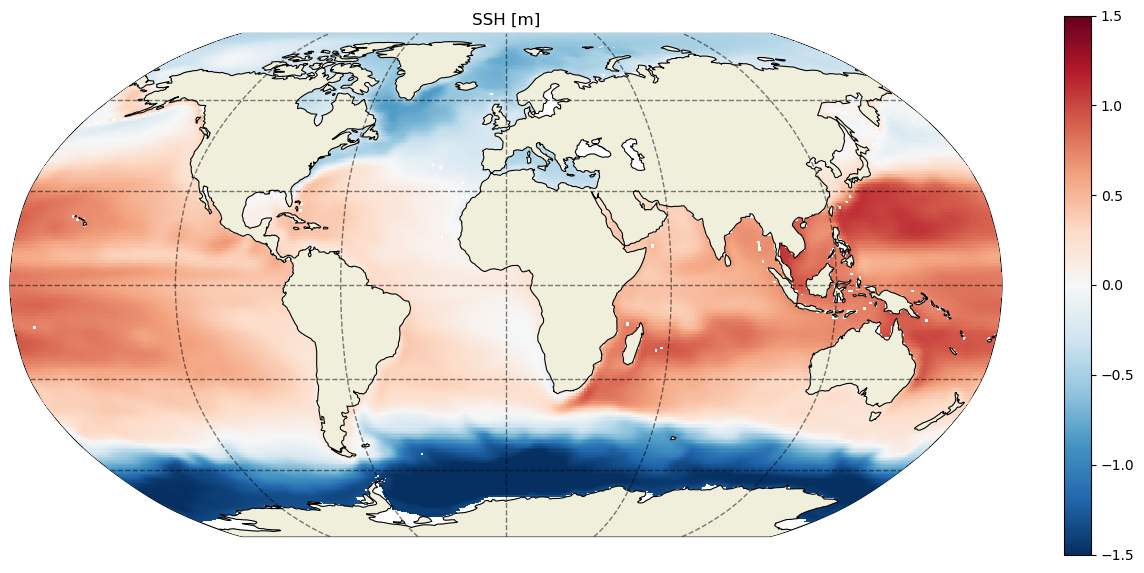

In [8]:
SSH  = SSH_dataset.SSH
# mask to nan where hFacC(k=0) = 0
SSH  = SSH.where(grid.hFacC.isel(k=0))

fig  = plt.figure(figsize=(16,7))
ecco.plot_proj_to_latlon_grid(grid.XC, grid.YC, SSH, show_colorbar=True, cmin=-1.5, cmax=1.5);plt.title('SSH [m]');

### Alternatively: use ``glob`` module to get file name

The ``open_dataset`` function in ``xarray`` requires an exact file name as input. Some of the file names of specific granules are quite long, and looking up the file name each time we want to use a new dataset is a little annoying.

This is where the ``glob`` module (generally included in Python distributions) can help us. It takes as input a pattern-matching expression for file names (the same as you would pass to ``ls`` in a Unix shell), and returns a Python list of those file names. In this case, we know that we want the Jan 2010 monthly mean SSH, and granule file names for a certain time always contain the expression YYYY-MM (for monthly mean files) or YYYY-MM-DD (for daily mean/snapshot files). So we can get the same result as above knowing only the dataset ShortName and the month we want to plot.

In [9]:
SSH_monthly_shortname = "ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4"
SSH_dir = join(ECCO_dir,SSH_monthly_shortname)

import glob
SSH_files = glob.glob(join(SSH_dir,'*_2010-01_*.nc'))
if len(SSH_files) > 0:
    SSH_dataset = xr.open_dataset(SSH_files[0])
    SSH_dataset
else:
    print('File not found')

<xarray.Dataset> Size: 7MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 8B 2010-01-16T12:00:00
    ...         ...
    YC         (tile, j, i) float32 421kB ...
    XG         (tile, j_g, i_g) float32 421kB ...
    YG         (tile, j_g, i_g) float32 421kB ...
    time_bnds  (time, nv) datetime64[ns] 16B ...
    XC_bnds    (tile, j, i, nb) float32 2MB ...
    YC_bnds    (tile, j, i, nb) float32 2MB ...
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 421kB ...
    SSHIBC     (time, tile, j, i) float32 421kB ...
    SSHNOIBC   (time, tile, j, i) float32 421kB ...
    ETAN       (time, tile, j, i) float32 421kB ...
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2010-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2010-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         9ce7afa6-400c-11eb-ab45-0cc47a3f49c3

We can see that the time coordinate is in the correct month.

## Opening a subset of a single ECCOv4 variable NetCDF file


Once an ``xarray`` dataset is opened in the workspace (*before* it is loaded into actual memory/RAM), it can be subset so that when you actually perform computations, they do not need to involve the entire dataset. This can be done using ``isel`` or ``sel``. ``isel`` accepts indices, which can be expressed as key/value pairs individually or as a dictionary of key/value pairs. The same is true of ``sel``, but it accepts dimension coordinates instead of indices; most dimensional coordinates in ECCOv4 output files are given as indices anyway, so there is not much difference (except for subsetting in time).

In the following example we open the monthly mean temperature/salinity file for Jan 2010, then create a subset for tiles 7,8,9 and depth levels 0:34.

In [10]:
temp_sal_monthly_shortname = "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4"

ds_temp_sal = xr.open_dataset(files_dict[temp_sal_monthly_shortname][0])

tiles_subset = [7,8,9]
k_subset = np.arange(0,34)    # includes k indices 0..33 (not including 34, per Python indexing convention)
ds_subset = ds_temp_sal.isel(tile=tiles_subset,k=k_subset)
ds_subset

<xarray.Dataset> Size: 8MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 34, k_u: 50, k_l: 50,
                k_p1: 51, tile: 3, time: 1, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 136B 0 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 200B ...
    Zl         (k_l) float32 200B ...
    time_bnds  (time, nv) datetime64[ns] 16B ...
    XC_bnds    (tile, j, i, nb) float32 389kB ...
    YC_bnds    (tile, j, i, nb) float32 389kB ...
    Z_bnds     (k, nv) float32 272B ...
Dimensions without coordinates: nv, nb
Data variables:
    THETA      (time, k, tile, j, i) float32 3MB ...
    SALT       (time, k, tile, j, i) float32 3MB ...
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               2010-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             2010-01-01T00:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            f4291248-4181-11eb-82cd-0cc47a3f446d

As expected, ``ds_subset`` has 3 tiles and 34 vertical levels. We can do the same thing, but pass both `tile` and `k` subset indices in a single dictionary; this is more convenient if we use these subsetting indices multiple times.

In [11]:
tiles_subset = [7,8,9]
k_subset = np.arange(0,34)    # includes k indices 0..33 (not including 34, per Python indexing convention)
dict_subset_ind = {'tile':tiles_subset,'k':k_subset}
ds_subset = ds_temp_sal.isel(dict_subset_ind)
ds_subset

<xarray.Dataset> Size: 8MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 34, k_u: 50, k_l: 50,
                k_p1: 51, tile: 3, time: 1, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 136B 0 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 200B ...
    Zl         (k_l) float32 200B ...
    time_bnds  (time, nv) datetime64[ns] 16B ...
    XC_bnds    (tile, j, i, nb) float32 389kB ...
    YC_bnds    (tile, j, i, nb) float32 389kB ...
    Z_bnds     (k, nv) float32 272B ...
Dimensions without coordinates: nv, nb
Data variables:
    THETA      (time, k, tile, j, i) float32 3MB ...
    SALT       (time, k, tile, j, i) float32 3MB ...
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               2010-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             2010-01-01T00:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            f4291248-4181-11eb-82cd-0cc47a3f446d

## Opening multiple files of a single ECCOv4 variable using ``open_mfdataset``

We've seen that ``open_dataset`` opens a single netCDF file in the workspace as an ``xarray`` dataset. The ``open_mfdataset`` does the same thing, but automatically concatenates multiple netCDF files based on the dimension and coordinate information in each, a very convenient feature!

Let's open all the monthly mean SSH files for 2010-2011 as a single dataset. Another convenience of ``open_mfdataset`` is that it parses pattern-matching strings in the same way that ``glob`` does. This allows ECCOv4 files across a range of times to be concatenated and opened in a single command.

In [12]:
# two years:  2010 and 2011

# use list comprehension to list file paths for 2010 and 2011
file_paths = [filepath for filepath in files_dict[ShortNames_list[1]]\
                 if (('_2010-' in filepath) or ('_2011-' in filepath))]
SSH_2010_2011 = xr.open_mfdataset(file_paths)

SSH_2010_2011

<xarray.Dataset> Size: 45MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 24, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 192B 2010-01-16T12:00:00 ... 2011-12-16T...
    ...         ...
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 384B dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 10MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHIBC     (time, tile, j, i) float32 10MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHNOIBC   (time, tile, j, i) float32 10MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    ETAN       (time, tile, j, i) float32 10MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2010-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2010-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         9ce7afa6-400c-11eb-ab45-0cc47a3f49c3

Notice that `SSH_2010_2011` has 24 time records. You can check that the times were concatenated in order:

In [13]:
SSH_2010_2011.time

<xarray.DataArray 'time' (time: 24)> Size: 192B
array(['2010-01-16T12:00:00.000000000', '2010-02-15T00:00:00.000000000',
       '2010-03-16T12:00:00.000000000', '2010-04-16T00:00:00.000000000',
       '2010-05-16T12:00:00.000000000', '2010-06-16T00:00:00.000000000',
       '2010-07-16T12:00:00.000000000', '2010-08-16T12:00:00.000000000',
       '2010-09-16T00:00:00.000000000', '2010-10-16T12:00:00.000000000',
       '2010-11-16T00:00:00.000000000', '2010-12-16T12:00:00.000000000',
       '2011-01-16T12:00:00.000000000', '2011-02-15T00:00:00.000000000',
       '2011-03-16T12:00:00.000000000', '2011-04-16T00:00:00.000000000',
       '2011-05-16T12:00:00.000000000', '2011-06-16T00:00:00.000000000',
       '2011-07-16T12:00:00.000000000', '2011-08-16T12:00:00.000000000',
       '2011-09-16T00:00:00.000000000', '2011-10-16T12:00:00.000000000',
       '2011-11-16T00:00:00.000000000', '2011-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 192B 2010-01-16T12:00:00 ... 2011-12-16T12...
Attributes:
    long_name:              center time of averaging period
    axis:                   T
    bounds:                 time_bnds
    coverage_content_type:  coordinate
    standard_name:          time

Notice also that ``open_mfdataset`` opens many variables in the form of a ``dask.array`` with the content of the variable divided into chunks. You can also use ``open_mfdataset`` to open a single netCDF file; however, in small datasets Dask arrays can slow down computations, so this is not always recommended. We will see some of the benefits of opening variables as Dask arrays soon.

We can also open the monthly mean SSH for *all* available times in the same way.

In [14]:
# all years
SSH_all = xr.open_mfdataset(files_dict[ShortNames_list[1]])

SSH_all

<xarray.Dataset> Size: 66MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 36, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 288B 2010-01-16T12:00:00 ... 2012-12-16T...
    ...         ...
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 576B dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 15MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHIBC     (time, tile, j, i) float32 15MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHNOIBC   (time, tile, j, i) float32 15MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    ETAN       (time, tile, j, i) float32 15MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2010-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2010-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         9ce7afa6-400c-11eb-ab45-0cc47a3f49c3

Now we have all 312 monthly mean records of SSH.

## Combining datasets using ``xarray.merge``

``xarray`` datasets can be merged to allow the user to more easily work with variables that were not contained in the same dataset or file to begin with. 

Say we want to look at the monthly mean sea surface height ``SSH`` and potential temperature ``THETA`` during 2010-2012. We can open the datasets containing them separately, and then merge them.

If we're not interested in including a certain variable (e.g., salinity ``SALT``, which is a large full depth variable that we don't need), then we can also avoid including it in the dataset to begin with by passing the ``drop_variables`` option to ``open_dataset`` or ``open_mfdataset``.

### Opening a dataset of SSH and THETA for 2010-2012

In [15]:
# use list comprehension to list file paths for 2010-2012, then open the files
file_paths = [filepath for filepath in files_dict[ShortNames_list[1]]\
                 if (('_2010-' in filepath) or ('_2011-' in filepath) or ('_2012-' in filepath))]
SSH_2010_2012 = xr.open_mfdataset(file_paths,drop_variables=['SSHIBC','SSHNOIBC','ETAN'])

file_paths = [filepath for filepath in files_dict[ShortNames_list[3]]\
                 if (('_2010-' in filepath) or ('_2011-' in filepath) or ('_2012-' in filepath))]
THETA_2010_2012 = xr.open_mfdataset(file_paths,drop_variables='SALT')


SSH_THETA_2010_2012 = xr.merge([SSH_2010_2012,THETA_2010_2012])

SSH_THETA_2010_2012

<xarray.Dataset> Size: 778MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 36, nv: 2,
                nb: 4, k: 50, k_u: 50, k_l: 50, k_p1: 51)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 288B 2010-01-16T12:00:00 ... 2012-12-16T...
    ...         ...
  * k_p1       (k_p1) int32 204B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
    Z          (k) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    Zp1        (k_p1) float32 204B dask.array<chunksize=(51,), meta=np.ndarray>
    Zu         (k_u) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    Z_bnds     (k, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 15MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    THETA      (time, k, tile, j, i) float32 758MB dask.array<chunksize=(1, 25, 7, 45, 45), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2010-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2010-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         9ce7afa6-400c-11eb-ab45-0cc47a3f49c3

We see three years (36 months) of data and 13 tiles and 50 vertical levels.

### Using a preprocess function to open a spatial subset of multiple files
Previously we had an example where we opened a single file as a dataset and then subsetted certain indices as a separate (smaller) dataset. What if we want a dataset with multiple times *and* a spatial subset? We could use ``open_mfdataset`` and then subset like we did before, or we can subset before the datasets are concatenated using a preprocess function. 

Let's try it both ways, to obtain a dataset that contains SSH and OBP monthly means during 2010 in a single tile (tile=6). For good measure, we'll use the ``time`` module and ``pympler`` package to track the time and memory footprint involved using each method. If you don't have [Pympler](https://pythonhosted.org/Pympler/index.html) installed already, you can use ``conda install pympler``, ``conda install -c conda-forge pympler``, or ``pip install pympler`` to get it on your system.

In [16]:
import time
from pympler import asizeof


# function to quantify memory footprint of a dataset
def memory_footprint(ds):
    s = 0
    for i in ds.variables.keys():
        s += asizeof.asizeof(ds[i])    
    return s



# Merge first then subset

start_time = time.time()

memory_footp = 0


file_paths = [filepath for filepath in files_dict[ShortNames_list[1]] if '_2010-' in filepath]
SSH_monthly_2010 = xr.open_mfdataset(file_paths)
file_paths = [filepath for filepath in files_dict[ShortNames_list[2]] if '_2010-' in filepath]
OBP_monthly_2010 = xr.open_mfdataset(file_paths)


memory_footp += memory_footprint(SSH_monthly_2010)
memory_footp += memory_footprint(OBP_monthly_2010)

SSH_OBP_monthly_2010 = xr.merge([SSH_monthly_2010,OBP_monthly_2010])
memory_footp += memory_footprint(SSH_OBP_monthly_2010)

SSH_OBP_2010_tile_6 = SSH_OBP_monthly_2010.isel(tile=6)
memory_footp += memory_footprint(SSH_OBP_2010_tile_6)

end_time = time.time()

print('Merge first then subset: ' + str(end_time - start_time) + ' sec elapsed')
print('Memory footprint: ' + str(memory_footp/(2**20)) + ' MB')

# delete datasets from first part to start fresh
del SSH_monthly_2010
del OBP_monthly_2010
del SSH_OBP_monthly_2010
del SSH_OBP_2010_tile_6



# Subset before merging

def subset(ds):
    dict_subset = {'tile':6}
    ds_subset = ds.isel(dict_subset)
    return ds_subset

start_time = time.time()

memory_footp = 0


file_paths = [filepath for filepath in files_dict[ShortNames_list[1]] if '_2010-' in filepath]
SSH_2010_tile_6 = xr.open_mfdataset(file_paths,preprocess=subset)
file_paths = [filepath for filepath in files_dict[ShortNames_list[2]] if '_2010-' in filepath]
OBP_2010_tile_6 = xr.open_mfdataset(file_paths,preprocess=subset)


memory_footp += memory_footprint(SSH_2010_tile_6)
memory_footp += memory_footprint(OBP_2010_tile_6)

SSH_OBP_2010_tile_6 = xr.merge([SSH_2010_tile_6,OBP_2010_tile_6])
memory_footp += memory_footprint(SSH_OBP_2010_tile_6)

end_time = time.time()

print('Subset first then merge: ' + str(end_time - start_time) + ' sec elapsed')
print('Memory footprint: ' + str(memory_footp/(2**20)) + ' MB')

Merge first then subset: 11.381447553634644 sec elapsed
Memory footprint: 111.52811431884766 MB
Subset first then merge: 8.979552745819092 sec elapsed
Memory footprint: 30.84374237060547 MB


We can see that subsetting individual datasets before concatenating and merging saves only a little bit of time, but a lot in terms of memory footprint. This matters when dealing with much larger datasets.

In [17]:
SSH_OBP_2010_tile_6

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, time: 12, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    tile       int32 6
  * time       (time) datetime64[ns] 2010-01-16T12:00:00 ... 2010-12-16T12:00:00
    ...         ...
    YC         (j, i) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
    XG         (j_g, i_g) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
    YG         (j_g, i_g) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (j, i, nb) float32 dask.array<chunksize=(90, 90, 4), meta=np.ndarray>
    YC_bnds    (j, i, nb) float32 dask.array<chunksize=(90, 90, 4), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    SSHIBC     (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    SSHNOIBC   (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    ETAN       (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    OBP        (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    OBPGMAP    (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    PHIBOT     (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2010-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2010-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         9ce7afa6-400c-11eb-ab45-0cc47a3f49c3

## Opening and handling very large ECCOv4 datasets using Dask

We can load the entire ECCOv4 solution into our workspace and perform calcuations with the entire solution thanks to the amazing ``Dask`` library implemented in the ``xarray`` package.  Why is this useful?  Because it is unlikely that the machine you are working on has enough RAM to load the entire ECCOv4 solution at one time.  By using ``Dask`` we can *virtually* load all of the ECCO fields into memory.  ``Dask`` even enables us to do calculations with these fields even though the entire data is never stored in memory.  

Here is some more information about these features from the ``Dask`` website, 
https://docs.dask.org/

1. **Larger-than-memory:** Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.*

2. **Blocked Algorithms:** Perform large computations by performing many smaller computations

Finally, in cluster environments ``Dask`` can distribute computations across many cores to speed up large redundant calculation.  

An in-depth description of ``Dask`` is outside the scope of this tutorial.  For the moment, let's load several monthly-mean variables for two years with and without ``Dask``.  Then we'll load the monthly-mean fields for three years using Dask.  Without ``Dask`` these fields will be loaded into memory.  With ``Dask`` we will only load a minimum of the ``Datasets``, the Dimensions and Coordinates. At the end we'll compare their *times to load* and *memory footprints*.

### Example 1: Load two years of monthly-mean ECCO fields into memory without ``Dask``

The ``.compute()`` suffix appended to an ``xarray`` Dataset or DataArray is a command to fully load fields into memory.  Without it, ``Dask`` only *virtually* loads the fields.

In [18]:
# list of shortnames to load datasets of
shortnames_list = ['ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4','ECCO_L4_OBP_LLC0090GRID_MONTHLY_V4R4',\
                   'ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4']
years_to_load = [2010,2011,2012]


# define function to open multiple datasets and years
def open_multi_datasets_years(shortnames_list,years_to_load):
    for count_short,shortname in enumerate(shortnames_list):
        for count_year,year in enumerate(years_to_load):
            file_paths = [filepath for filepath in files_dict[shortname] if str(year) in filepath]
            if count_year == 0:
                ds_curr = xr.open_mfdataset(file_paths)
            else:
                ds_new = xr.open_mfdataset(file_paths)
                ds_curr = xr.concat([ds_curr,ds_new],dim='time')
        if count_short == 0:
            ds = ds_curr
        if count_short > 0:
            ds = xr.merge([ds,ds_curr])
    
    return ds

# load fields into memory without Dask

t_0 = time.time()

ds = open_multi_datasets_years(shortnames_list,years_to_load)
ds_no_dask = ds.compute()

delta_t_3_yrs_no_dask =  time.time() - t_0
print(str(delta_t_3_yrs_no_dask) + ' sec elapsed')

25.378690481185913 sec elapsed


### Example 2: Open three years of monthly-mean ECCO fields using ``Dask``

This time we will omit the ``.compute()`` suffix and use ``Dask``.

In [19]:
t_0 = time.time()

ds = open_multi_datasets_years(shortnames_list,years_to_load)
ds_with_dask = ds

delta_t_3_yrs_with_dask =  time.time() - t_0
print(str(delta_t_3_yrs_with_dask) + ' sec elapsed')

11.893571615219116 sec elapsed


### Results

Now we examine the time it took to load these fields and the comparative memory footprints

In [20]:
print ('loaded 3 years without dask in ', delta_t_3_yrs_no_dask, ' sec')
print ('loaded 3 years with_dask in    ', delta_t_3_yrs_with_dask, ' sec')

loaded 3 years without dask in  25.378690481185913  sec
loaded 3 years with_dask in     11.893571615219116  sec


The real advantage of using Dask comes when examining the size of these objects in memory.

In [21]:
# Estimate the memory footprint in MB

s = memory_footprint(ds_no_dask)
print('ds_no_dask   : ', np.round(s/2**20), 'mb')

s = memory_footprint(ds_with_dask)
print('ds_with_dask : ', np.round(s/2**20), 'mb')

ds_no_dask   :  1566.0 mb
ds_with_dask :  25.0 mb


Opening/viewing datasets using ``Dask`` uses much less memory than loading the full dataset with ``.load()``.  ``Dask`` uses this "lazy" approach to handling datasets, deferring loading fields into memory and performing calculations until the last possible moment. Combined with Dask's chunking of datasets, this means that computations can be done even on data spanning much larger sizes than your machine's RAM.

## Summary

Now you know efficient ways to open and view the contents of ECCOv4 NetCDF files, including how to concatenate, merge, and subset across multiple times and datasets.

Using ``Dask`` we showed that one can prepare a work environment where ECCO model variables are accessible for calculations even without fully loading the fields into memory.